In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Defining data file paths
DEM_PATH_1955  = "/home/matthaeus/Downloads/dem_morteratsch_1955.txt"
MASK_PATH_1955 = "/home/matthaeus/Downloads/glacier_mask_1955.txt"
DEM_PATH_2008  = "/home/matthaeus/Downloads/dem_morteratsch_2008.txt"
MASK_PATH_2008 = "/home/matthaeus/Downloads/glacier_mask_2008.txt"

In [4]:
def load_metadata(file_path):
    with open(file_path, 'r') as infile:
        meta_data_dict = {}
        for line_idx in range(6):
            descriptor, value = infile.readline().split()
            meta_data_dict[descriptor.lower()] = value
        return meta_data_dict
    
def load_data(file_path):
    return np.genfromtxt(file_path, skip_header=6)

In [5]:
# Loading all data
meta_data_1955 = load_metadata(DEM_PATH_1955)
dem_data_1955 = load_data(DEM_PATH_1955)
rock_mask_1955 = load_data(MASK_PATH_1955)
meta_data_2008 = load_metadata(DEM_PATH_2008)
dem_data_2008 = load_data(DEM_PATH_2008)
rock_mask_2008 = load_data(MASK_PATH_2008)

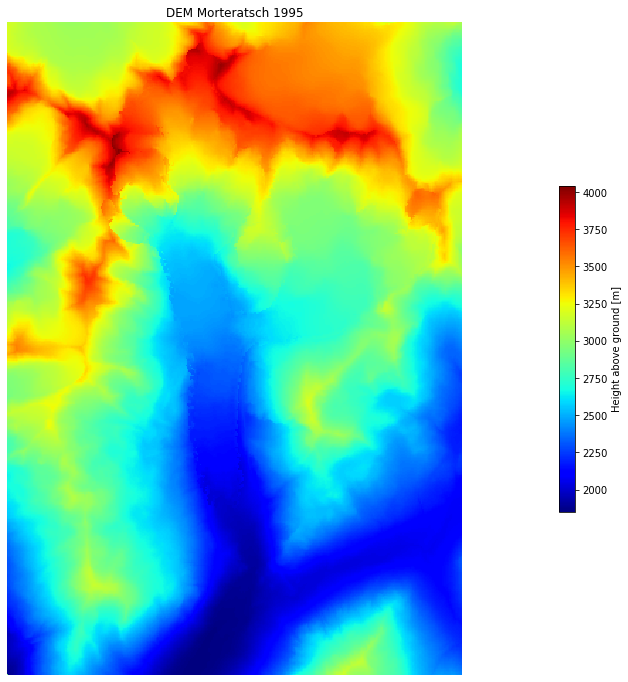

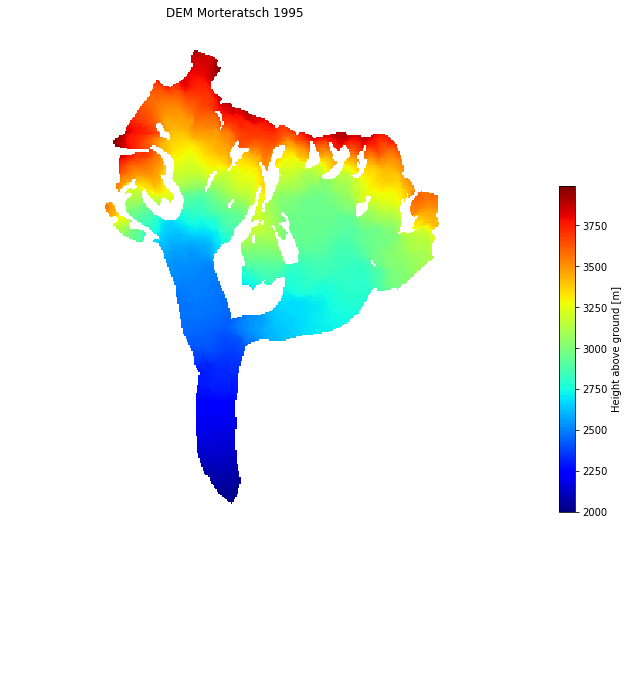

In [6]:
def mask_data(dem_data, mask, fill_masked_val='nan'):
    data = dem_data.copy()
    mask_inv = 1 - mask
    np.putmask(data, mask_inv, 0)
    data[data == 0] = fill_masked_val
    return data
    
def plot_height_map(data, title='', cb_label='', mask=None, cmap='jet', do_col_bar=True):
    data = data.copy()
    if mask is not None:
        data = mask_data(data, mask)
    flipped = np.flipud(data)
    fig, ax = plt.subplots(figsize=(35, 12))
    plot = ax.imshow(flipped, cmap=cmap)
    ax.set_xlabel('x coordinate')
    ax.set_ylabel('y coordinate')
    ax.set_title(title)
    ax.axis('off')
    if do_col_bar:
        fig.colorbar(plot, shrink=0.5, aspect=20, label=cb_label)
    plt.show()

# Plot height maps
plot_height_map(dem_data_1955, title='DEM Morteratsch 1995', cb_label='Height above ground [m]')
plot_height_map(dem_data_1955, mask=rock_mask_1955, title='DEM Morteratsch 1995', cb_label='Height above ground [m]')
# plot_height_map(dem_data_2008, title='DEM Morteratsch 2008')
# plot_height_map(dem_data_2008, mask=rock_mask, title='DEM Morteratsch 2008')

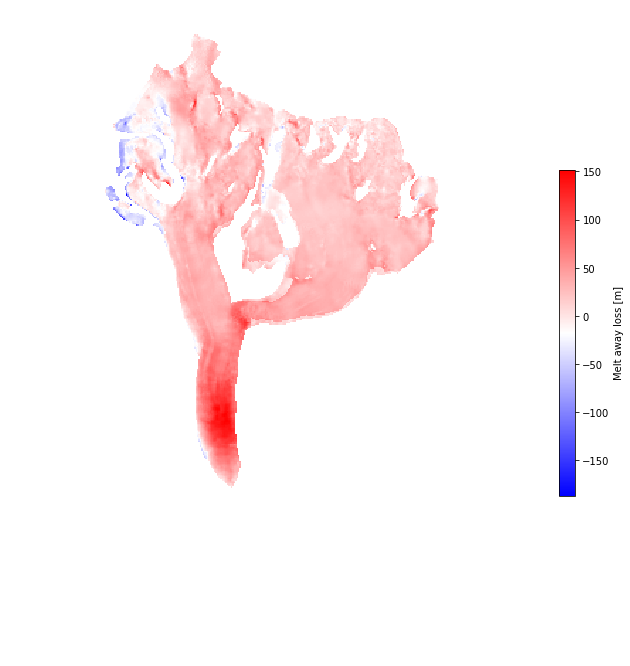

In [8]:
# Plot height difference with 1995 mask applied
difference = mask_data(dem_data_1955, rock_mask_1955, fill_masked_val=0) \
           - mask_data(dem_data_2008, rock_mask_1955, fill_masked_val=0)
plot_height_map(difference, mask=rock_mask_1955, cb_label='Melt away loss [m]', cmap='bwr')

In [ ]:
# trapz2d functino taken from the web...
def trapz2d(z, x=None,y=None,dx=25,dy=25):
    """Integrates a regularly spaced 2D grid using the composite trapezium rule. 
    Arguments
    ---------
       z : 2D array
       x : (optional) grid values for x (1D array)
       y : (optional) grid values for y (1D array)
       dx: if x is not supplied, set it to the x grid interval
       dy: if y is not supplied, set it to the x grid interval
    """
    import numpy as N
    
    sum = N.sum
    if x != None:
        dx = (x[-1]-x[0])/(N.shape(x)[0]-1)
    if y != None:
        dy = (y[-1]-y[0])/(N.shape(y)[0]-1)    
    
    s1 = z[0,0] + z[-1,0] + z[0,-1] + z[-1,-1]
    s2 = sum(z[1:-1,0]) + sum(z[1:-1,-1]) + sum(z[0,1:-1]) + sum(z[-1,1:-1])
    s3 = sum(z[1:-1,1:-1])
    
    return 0.25*dx*dy*(s1 + 2*s2 + 4*s3)

In [1]:
volume_1955 = trapz2d(mask_data(dem_data_1955, rock_mask_1955, fill_masked_val=0))
volume_2008 = trapz2d(mask_data(dem_data_2008, rock_mask_2008, fill_masked_val=0))
difference = dem_data_1955 - dem_data_2008
vol_decrease = trapz2d(difference)
print(f'The glacier lost {round(vol_decrease, 2)} m^3 of ice in {2008 - 1955} years.')

NameError: name 'trapz2d' is not defined

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def plot_3d_surface(data, show_plot=True):
    """This function plots a 3D surface of DEM data. Zero values are ignored.
    Arguments
    ---------
        data: A 2D numpy array holding DEM values
        show_plot: Basically whether to open the figure (plt.show() gets called)
    """
    # Transform it to a long format
    data = pd.DataFrame(data)
    df=data.unstack().reset_index()
    df.columns=["X", "Y", "Z"]

    # And transform the old column name in something numeric
    df['X']=pd.Categorical(df['X'])
    df['X']=df['X'].cat.codes
    df['Z'].replace(0, np.nan, inplace=True)  # Make zeros to nan to be ignored in the plot
    
    # Initialize the plot
    fig = plt.figure(figsize=(20, 15))
    ax = fig.gca(projection='3d')
    ax.view_init(45, 210)
    
    # Do the actual plot
    surf=ax.plot_trisurf(df['Y'], df['X'], df['Z'], cmap=plt.cm.viridis, linewidth=0.2,
                        vmin=np.nanmin(df['Z']), vmax=np.nanmax(df['Z']))
    fig.colorbar(surf, shrink=0.5, aspect=20, label='Height [m]')
    plt.show()

df = plot_3d_surface(mask_data(dem_data_1955, rock_mask_1955, fill_masked_val=0))

In [ ]:
import numpy as np
from scipy.interpolate import RectBivariateSpline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Regularly-spaced, coarse grid
dx, dy = 0.4, 0.4
xmax, ymax = 2, 4
x = np.arange(-xmax, xmax, dx)
y = np.arange(-ymax, ymax, dy)
X, Y = np.meshgrid(x, y)
Z = np.exp(-(2*X)**2 - (Y/2)**2)

interp_spline = RectBivariateSpline(y, x, Z)

# Regularly-spaced, fine grid
dx2, dy2 = 0.16, 0.16
x2 = np.arange(-xmax, xmax, dx2)
y2 = np.arange(-ymax, ymax, dy2)
X2, Y2 = np.meshgrid(x2,y2)
Z2 = interp_spline(y2, x2)

fig, ax = plt.subplots(nrows=1, ncols=2, subplot_kw={'projection': '3d'})
ax[0].plot_wireframe(X, Y, Z, color='k')

ax[1].plot_wireframe(X2, Y2, Z2, color='k')
for axes in ax:
    axes.set_zlim(-0.2,1)
    axes.set_axis_off()



In [ ]:
meta_data_1955

In [ ]:
step      = int(float(meta_data_1955['cellsize']))
xllcorner = float(meta_data_1955['xllcorner'])
yllcorner = float(meta_data_1955['yllcorner'])
nrows     = int(float(meta_data_1955['nrows']))
ncols     = int(float(meta_data_1955['ncols']))
xlrcorner = xllcorner + ncols * step
yulcorner = yllcorner - nrows * step

print('Integration bounds:')
print(f'x: [{xllcorner} - {xlrcorner}]')
print(f'y: [{yulcorner} - {yllcorner}]')

In [ ]:
x = np.arange(xllcorner, xlrcorner, step)
y = np.arange(yulcorner, yllcorner, step)
X, Y = np.meshgrid(x, y)

fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(13, 8))
_ = ax.plot_wireframe(X, Y, dem_data_1955, color='b', linewidth=0.3)
fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(13, 8))
masked_data = mask_data(dem_data_1955, rock_mask_1955, fill_masked_val=0)
_ = ax.plot_wireframe(X, Y, masked_data, color='b', linewidth=1)

In [ ]:
interp_spline = RectBivariateSpline(y, x, data)
test_x = 712500
test_y = 134000
interpolated_value = interp_spline(test_x, test_y)
print(interpolated_value)
Z = interp_spline(y, x)

In [ ]:
x2 = np.arange(xllcorner, xlrcorner, step*10)
y2 = np.arange(yulcorner, yllcorner, step*10)
X2, Y2 = np.meshgrid(x2, y2)
Z2 = interp_spline(y2, x2)
fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(13, 8))
_ = ax.plot_wireframe(X2, Y2, Z2, color='b')

In [ ]:
plt.imshow(Z)

In [ ]:
plt.imshow(Z2)

In [ ]:
masked_data1955 = mask_data(dem_data_1955, rock_mask_1955, fill_masked_val=0)
masked_data2008 = mask_data(dem_data_2008, rock_mask_1955, fill_masked_val=0)

In [ ]:
interp1955 = RectBivariateSpline(y, x, masked_data1955)
interp2008 = RectBivariateSpline(y, x, masked_data2008)

In [ ]:
integral_1955, err1955 = dblquad(interp1955, xllcorner, xlrcorner, lambda y: yulcorner, lambda y: yllcorner)
integral_2008, err2008 = dblquad(interp2008, xllcorner, xlrcorner, lambda y: yulcorner, lambda y: yllcorner)

In [ ]:
vol_decrease = integral_1955 - integral_2008

In [ ]:
print(vol_decrease/1000000000)

In [ ]:
integral_1955

In [ ]:
integral_2008

In [ ]:
1400000000 / 1000000000

In [ ]:
1400000000 / 1000000000

In [ ]:
difference = mask_data(dem_data_1955, rock_mask_1955, fill_masked_val=0) \
           - mask_data(dem_data_2008, rock_mask_1955, fill_masked_val=0)
interp = RectBivariateSpline(y, x, difference)
integral, err = dblquad(interp, xllcorner, xlrcorner, lambda y: yulcorner, lambda y: yllcorner)

In [ ]:
integral, err

In [ ]:
integral / 1000000000

In [ ]:
masked_data1955

In [ ]:
masked_data2008

In [ ]:
mask

In [ ]:
plot_height_map(rock_mask_1955 - rock_mask_2008, cmap='bwr')